In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gwpy.plot import Plot
from pycbc import psd as pypsd
from pycbc.inference.models import GaussianNoise
from pycbc.noise.gaussian import frequency_noise_from_psd
from pycbc.waveform.generator import (FDomainDetFrameGenerator,FDomainCBCGenerator)
from pycbc.psd import EinsteinTelescopeP1600143
from pycbc.conversions import mchirp_from_mass1_mass2, q_from_mass1_mass2, mass1_from_mchirp_q, mass2_from_mchirp_q
import generation_signal


/home/victor/miniconda3/envs/pycbc_env/lib/python3.9/site-packages/pycbc/inference/models/__init__.py:24: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import iter_entry_points as _iter_entry_points


### Génération du signal
Paramètre du signal initial que l'on génère :

In [4]:
sample_rate = 2048
fmin = 5.
cbc_params = {
            # Paramètres intrinsèques à la source
            'mass1': 38.6,
            'mass2': 29.3,
            'spin1x': 0., 'spin2x': 0.,  'spin1y': 0., 'spin2y': 0.,  'spin1z': 0., 'spin2z': 0.,
            'eccentricity': 0,
            # Paramètres extrinsèques
            'ra': 1.37, 'dec': -1.26, 'distance': 1500,
            'polarization': 2.76, 'inclination': 0,
            'tc': 3.1 , 'coa_phase': 0}

para_reels = [3.1, 38.6, 29.3, 1500, 1.37, -1.26, 2.76, 0, 0, 0]

model, log_noise_likelihood_from_SNR, signal_noise = generation_signal.generation_signal_GW(cbc_params,sample_rate,
                                                                              fmin,noise=False,print_snr=True)

SNR E1: 203.90
SNR E2: 224.40
SNR E3: 181.19
Expected minus loglr: -62380.58
loglr : 62380.580991396026


### Minimisation en utilisant un DataFrame : minimums LOCAUX

Fonction scipy.optimize.minimize, charger les données depuis un fichier csv :

In [28]:
nom_fichier = "params_dataFrame_file_chirp_noise.txt"

params_dataFrame = pd.read_csv("data_files/" + nom_fichier)
para_opti = params_dataFrame.loc[params_dataFrame['mloglik'].idxmin()]

### Minimisation en utilisant un DataFrame : minimums GLOBAUX

On utilise cette fois la fonction scipy.optimize.basinhopping, charger les données depuis un fichier csv :

In [7]:
nom_fichier = 'params_glob_dataFrame_file_chirp.txt'

params_dataFrame_glob = pd.read_csv("data_files/" + nom_fichier)
para_opti = params_dataFrame_glob.loc[params_dataFrame_glob['mloglik'].idxmin()]

### Comparaison des signaux.

Conversion du signal réel dans le domaine temporel.

In [5]:
TSE1_reel = signal_noise['E1'].to_timeseries()
TSE2_reel = signal_noise['E2'].to_timeseries()
TSE3_reel = signal_noise['E3'].to_timeseries()

Génération et conversion en temporel d'un signal généré à partir des paramètres optimaux de minimisation.

In [2]:
from pycbc.types import FrequencySeries
from gwpy.timeseries import TimeSeries
from pycbc.types import TimeSeries as PycbcTimeSeries

import sys
sys.path.append('/home/victor/Internship_Victor_CBC_ET/code_Adrian/MLE_pipeline/src')
from get_data import get_psd_frequency_series, read_MDC_data, convert_to_frequency_series_with_psd, convert_data_dict_to_frequency_series_dict

path_data = '/home/victor/Internship_Victor_CBC_ET/code_Adrian/MLE_pipeline/data/'
data = {}
signal = {}
ifos=['E1', 'E2', 'E3']
for ifo in ifos:
    channel = ifo + ':STRAIN'
    file = path_data + 'données_' + ifo + '.txt'
    data[ifo] = TimeSeries.read(file)
    data[ifo] = data[ifo].resample(4096)
    val = data[ifo].value
    delta_t = data[ifo].dt.value
    pycbc_ts = PycbcTimeSeries(val, delta_t=delta_t)
    signal[ifo] = pycbc_ts.to_frequencyseries()

/home/victor/miniconda3/envs/pycbc_env/lib/python3.9/site-packages/gwpy/timeseries/timeseries.py:930: UserWarning: resample() rate matches current sample_rate (4096.0 Hz), returning input data unmodified; please double-check your parameters
  warnings.warn(
/home/victor/miniconda3/envs/pycbc_env/lib/python3.9/site-packages/gwpy/timeseries/timeseries.py:930: UserWarning: resample() rate matches current sample_rate (4096.0 Hz), returning input data unmodified; please double-check your parameters
  warnings.warn(


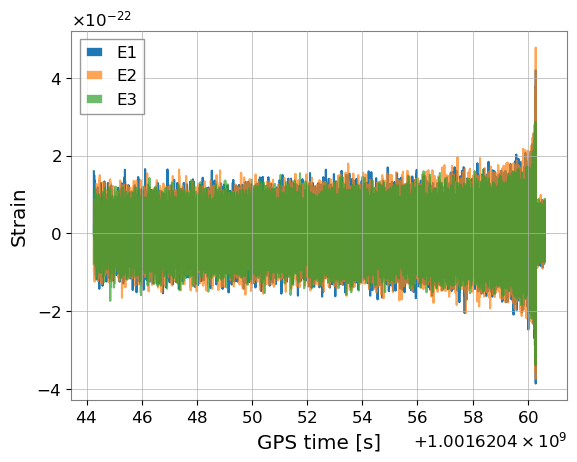

In [3]:
plt.figure()
ax = plt.gca()
ax.plot(data['E1'].times, data['E1'], label='E1')
ax.plot(data['E2'].times, data['E2'], label='E2', alpha=0.7)
ax.plot(data['E3'].times, data['E3'], label='E3', alpha=0.7)

ax.set_xlabel('GPS time [s]')
ax.set_ylabel('Strain')
ax.legend()

In [4]:
TSE1_reel = signal['E1'].to_timeseries()
TSE2_reel = signal['E2'].to_timeseries()
TSE3_reel = signal['E3'].to_timeseries()

In [18]:
params_opti_file = pd.read_csv('/home/victor/Internship_Victor_CBC_ET/code_Adrian/MLE_pipeline/src/result_mini.txt')
print(params_opti_file['mass1'].values[0])


25.06986477025291


In [46]:
from generate_data import generate_frequency_domain_signal

mchirp_true = params_opti_file['chirp'].values[0]
q_true = params_opti_file['q'].values[0]
para_opti = [ params_opti_file['tc'].values[0],  mass1_from_mchirp_q(mchirp_true, q_true),  mass2_from_mchirp_q(mchirp_true, q_true),
              params_opti_file['distance'].values[0], params_opti_file['ra'].values[0], params_opti_file['dec'].values[0],  params_opti_file['polarization'].values[0], params_opti_file['inclination'].values[0],
             params_opti_file['spin1z'].values[0],  params_opti_file['spin2z'].values[0], params_opti_file['coa_phase'].values[0]]
list_params = ['tc','mass1','mass2','distance','ra','dec','polarization','inclination','spin1z','spin2z','coa_phase']
maximized_params = dict(zip(list_params, para_opti))
cbc_params_stat = {'spin1x': 0., 'spin2x': 0.,  'spin1y': 0., 'spin2y': 0.,
    'eccentricity': 0}
cbc_params_stat ['approximant'] = 'IMRPhenomXPHM'
cbc_params_stat ['f_lower'] = 5

para_opti={**maximized_params, **cbc_params_stat}


reconstructed_signal_fdomain = generate_frequency_domain_signal(para_opti, epoch=1001620399.26659 + 45)

ifos=['E1', 'E2', 'E3']
reconstructed_signal_tdomain = {}
for ifo in ifos:
    reconstructed_signal_tdomain[ifo] = reconstructed_signal_fdomain[ifo].to_timeseries() # Just an inverse FFT




Waveform approximate duration: 55.1s
Segment duration: 64.0s


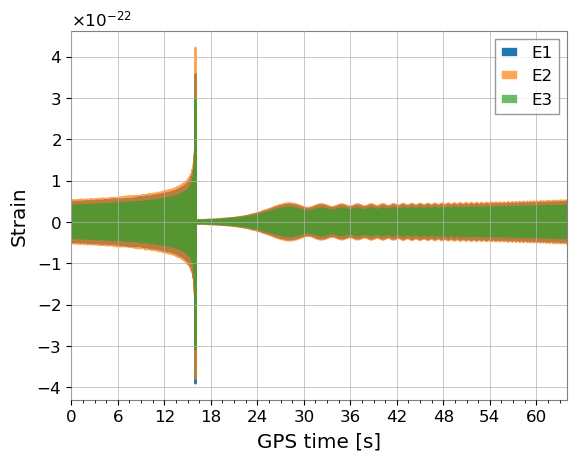

In [47]:
plt.figure()
ax = plt.gca()
ax.plot(reconstructed_signal_tdomain['E1'].get_sample_times(), reconstructed_signal_tdomain['E1'], label='E1')
ax.plot(reconstructed_signal_tdomain['E2'].get_sample_times(), reconstructed_signal_tdomain['E2'], label='E2', alpha=0.7)
ax.plot(reconstructed_signal_tdomain['E3'].get_sample_times(), reconstructed_signal_tdomain['E3'], label='E3', alpha=0.7)

ax.set_xlabel('GPS time [s]')
ax.set_ylabel('Strain')
ax.set_xscale('seconds', epoch=(1001620399.26659 + 45))
ax.legend()
#ax.set_xlim(1001620399.26659 + 45, 1001620463.11925 - 2.5)

SNR E1: 325.66
SNR E2: 352.92
SNR E3: 272.94
Expected minus loglr: -152551.41
loglr : -235495.41630174813


(1001620444.26659, 1001620460.61925)

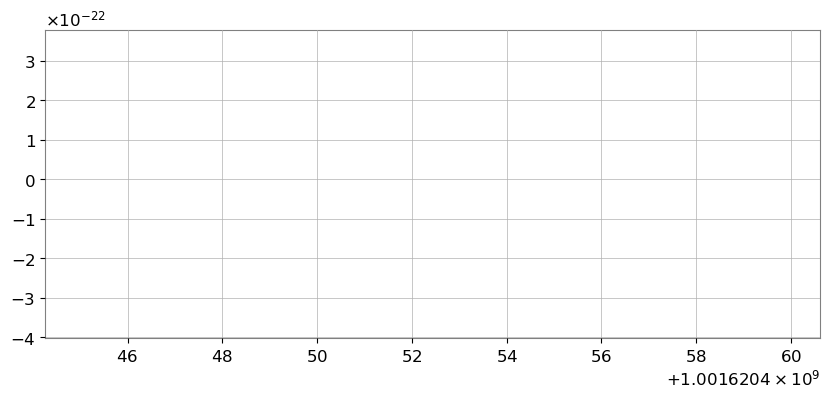

In [34]:
# Paramètres d'un signal de CBC (16 en tout)
mchirp_true = 2.10470526e+01
q_true = 1.03421289e+00

sample_rate = 2048
fmin = 5

para_opti = [ 1.00162046e+09,  mass1_from_mchirp_q(mchirp_true, q_true),  mass2_from_mchirp_q(mchirp_true, q_true),
               6.55524744e+02, 2.42974525e+00, -3.29182818e-01,  1.33204702e+00,  1.10655718e+00,
             1.81821699e-03,  1.67455630e-01]


cbc_params_opti = {
              # Paramètres intrinsèques à la source
              'mass1': para_opti[1],
              'mass2': para_opti[2],
              'spin1x': 0., 'spin2x': 0.,  'spin1y': 0., 'spin2y': 0.,  'spin1z': para_opti[8], 'spin2z': para_opti[9],
              'eccentricity': 0,
              # Paramètres extrinsèques
              'ra': para_opti[4], 'dec': para_opti[5], 'distance': para_opti[3],
              'polarization': para_opti[6], 'inclination': para_opti[7],
              'tc': para_opti[0] , 'coa_phase': 0}

model_opti, log_noise_likelihood_from_SNR_opti, signalGW_ET_opti = generation_signal.generation_signal_GW(cbc_params_opti,sample_rate,
                                                                              fmin,noise=False,print_snr=True)


TSE1_opti = signalGW_ET_opti['E1'].to_timeseries()
TSE2_opti = signalGW_ET_opti['E2'].to_timeseries()
TSE3_opti = signalGW_ET_opti['E3'].to_timeseries()

TSE1_opti_time = signalGW_ET_opti['E1'].to_timeseries()
# t_end = TSE1_opti_time.get_sample_times()[-1]
# TSE1_opti_time = TSE1_opti_time.cyclic_time_shift(t_end - signal.tc)
# plt.plot(TSE1_opti_time.get_sample_times(),TSE1_opti_time)

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(TSE1_opti_time.get_sample_times(),TSE1_opti_time)
#ax.set_xscale('seconds', epoch=(1001620399.26659))
ax.set_xlim(1001620399.26659 + 45, 1001620463.11925 - 2.5)
#ax.plot(TSE1_reel.get_sample_times(),TSE1_reel, label='E1', color='orange')

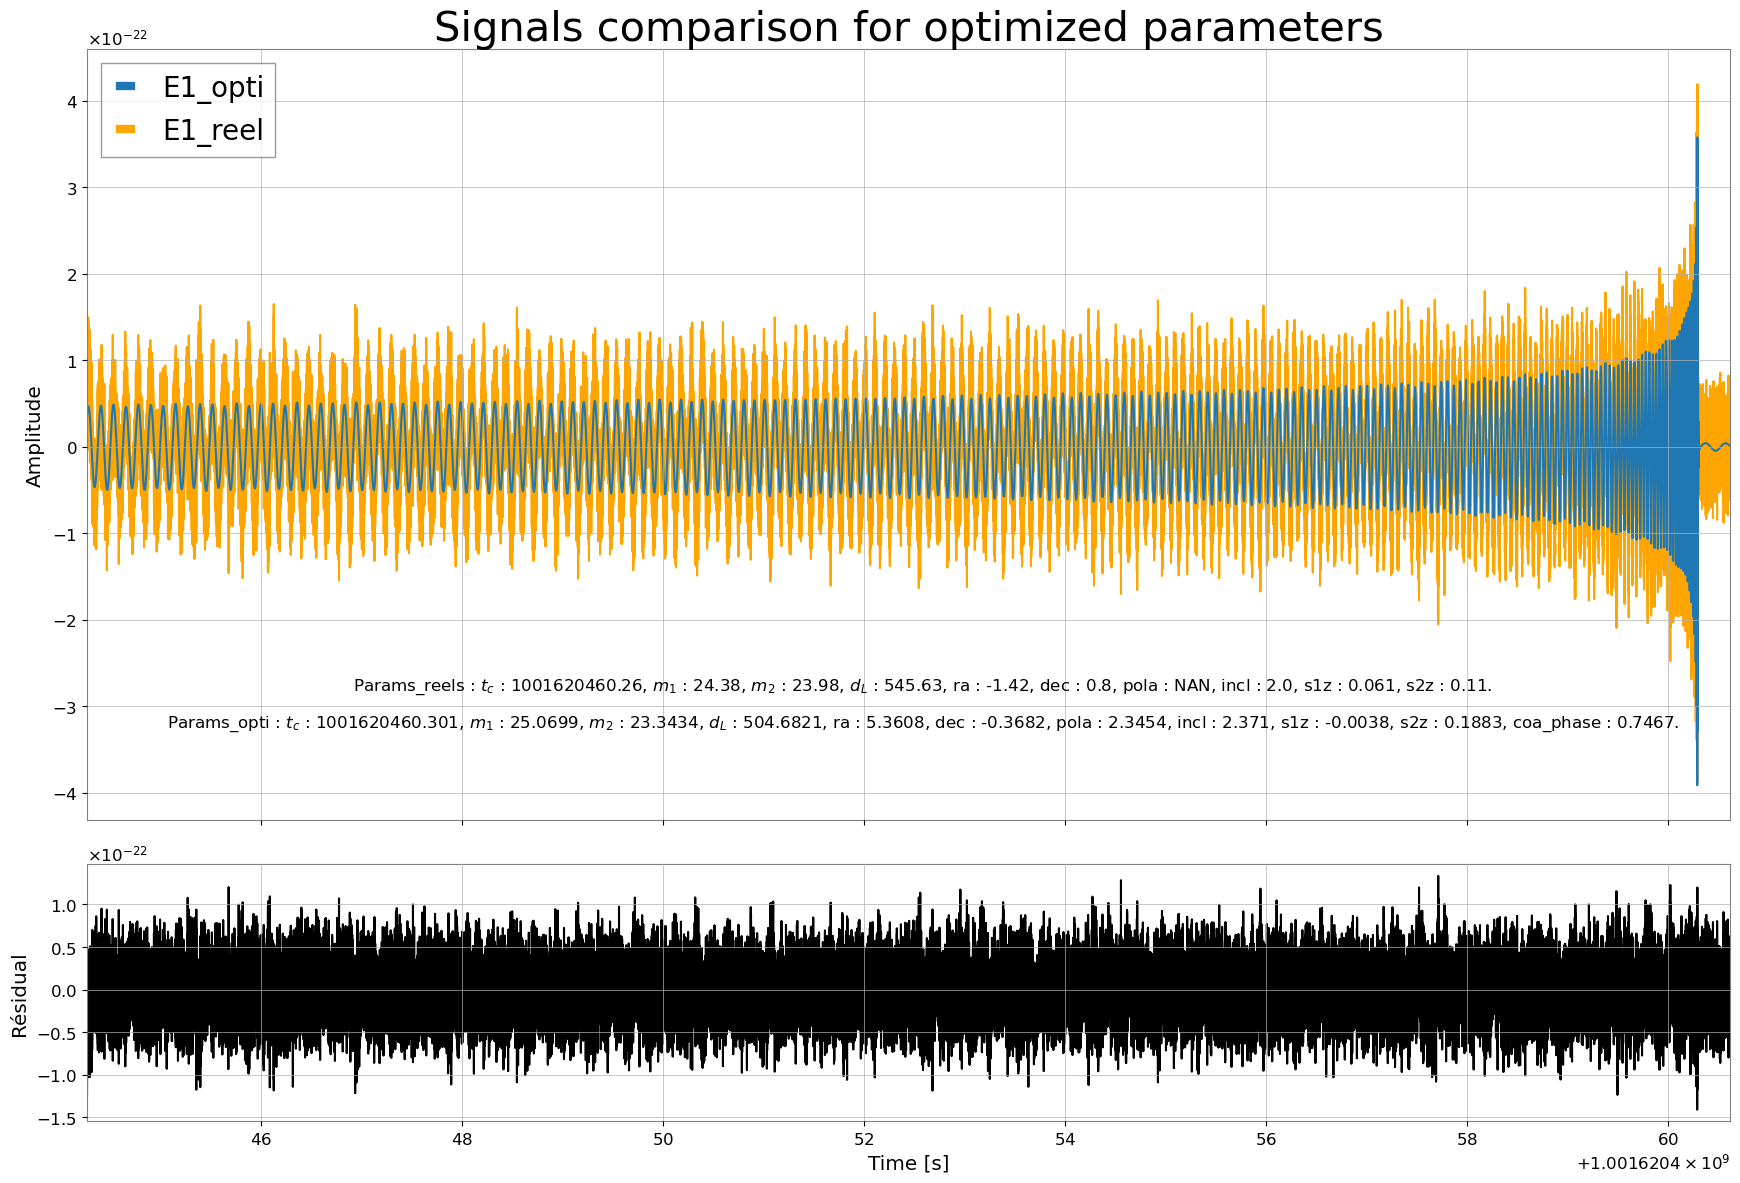

In [113]:
# Calcul de la différence
#residual = reconstructed_signal_tdomain['E1'] - trunc_data['E1']

mchirp_true = params_opti_file['chirp'].values[0]
q_true = params_opti_file['q'].values[0]
para_opti = [0, params_opti_file['tc'].values[0],  mass1_from_mchirp_q(mchirp_true, q_true),  mass2_from_mchirp_q(mchirp_true, q_true),
               params_opti_file['distance'].values[0], params_opti_file['ra'].values[0], params_opti_file['dec'].values[0],  params_opti_file['polarization'].values[0], params_opti_file['inclination'].values[0],
             params_opti_file['spin1z'].values[0],  params_opti_file['spin2z'].values[0], params_opti_file['coa_phase'].values[0]]
#24.386689 23.987984 0.0756 -0.023644 0.037543 0.061211 0.1384 -0.080838 0.007908 0.112059 0 0 0.1137 545.6354 -1.418225 0.795954 1.295625 2.002555 2.949147 587.553918 653.770127 3
para_reels = [1.001620460259506941e+09, 24.38, 23.98, 545.63, -1.42, 0.80, 'NAN', 2.00, 0.061,0.11]

# Création des subplots : 2 lignes, 1 colonne, partagent l'axe X
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Tracer les deux signaux dans le premier axe
ax1.plot(reconstructed_signal_tdomain['E1'].get_sample_times(),reconstructed_signal_tdomain['E1'],label='E1_opti', zorder = 2)
ax1.set_xlim(1001620399.26659 + 45, 1001620463.11925 - 2.5)
#ax1.set_xlim(1001620399.26659 + 45, 1001620463.11925 - 14)
#ax1.set_xlim(1001620399.26659 + 60, 1001620463.11925 - 2.6)
ax.set_xscale('seconds', epoch=(1001620399.26659 + 45))
ax1.plot(data['E1'].times,data['E1'], color='orange',label='E1_reel',zorder = 1)
ax1.set_title('Signals comparison for optimized parameters', fontsize = 30)
ax1.set_ylabel('Amplitude')
ax1.text(1.7, 1.1, r'Params_opti : $t_c$ : {}, $m_1$ : {}, $m_2$ : {}, $d_L$ : {}, ra : {}, dec : {}, pola : {}, incl : {}, s1z : {}, s2z : {}, coa_phase : {}.'.format(round(para_opti[1],3),
     round(para_opti[2],4), round(para_opti[3],4), round(para_opti[4],4), round(para_opti[5],4),round(para_opti[6],4), round(para_opti[7],4),round(para_opti[8],4),
     round(para_opti[9],4),round(para_opti[10],4),round(para_opti[11],4)), horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes,fontsize=12)
ax1.text(1.7, 1.2, r'Params_reels : $t_c$ : {}, $m_1$ : {}, $m_2$ : {}, $d_L$ : {}, ra : {}, dec : {}, pola : {}, incl : {}, s1z : {}, s2z : {}.'.format(round(para_reels[0],3),
      para_reels[1], para_reels[2], para_reels[3], para_reels[4], para_reels[5], para_reels[6], para_reels[7], para_reels[8], para_reels[9]), horizontalalignment='center',
      verticalalignment='center', transform=ax.transAxes,fontsize=12)
ax1.legend(fontsize=20)

val = data['E1'].value
delta_t = data['E1'].dt.value
data_E1 = PycbcTimeSeries(val, delta_t=delta_t, epoch = reconstructed_signal_tdomain['E1'].start_time)


#===========================
start_common = max(reconstructed_signal_tdomain['E1'].start_time, data['E1'].t0.value)
end_common = min(reconstructed_signal_tdomain['E1'].end_time, data['E1'].t0.value + data['E1'].duration.value)
opti_cut = reconstructed_signal_tdomain['E1'].time_slice(start_common, end_common)
reel_cut = data_E1.time_slice(start_common, end_common)

residual = opti_cut - reel_cut 

# Tracer la différence dans le second axe
ax2.plot(residual.get_sample_times(), residual, color='black')
ax2.set_ylabel('Résidual')
ax2.set_xlabel('Time [s]')


plt.tight_layout()
plt.savefig("Full_loc_minim_L1_Comparaison_signal")

Comparaison de signau dans le domaine fréquentiel :

Text(0, 0.5, 'PSD [1/Hz]')

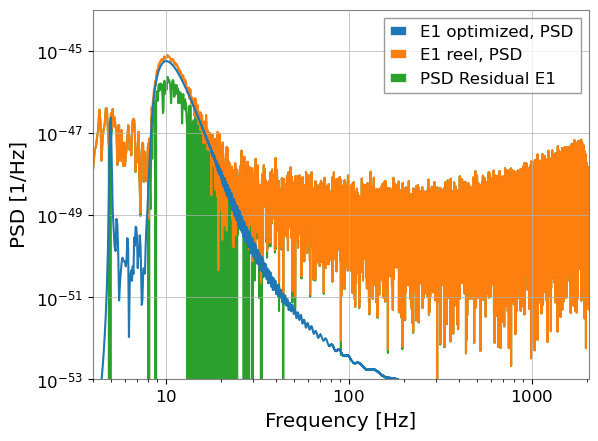

In [174]:
#Conversion en GwpyTimeseries ======================
tsgwpy_opti_cut = TimeSeries(data = opti_cut,times=opti_cut.get_sample_times())
tsgwpy_reel_cut = TimeSeries(data = reel_cut,times=reel_cut.get_sample_times())
tsgwpy_res = TimeSeries(data = residual,times=residual.get_sample_times())

#Calcul des psd
psd_opti = tsgwpy_opti_cut.psd()
psd_reel = data['E1'].psd()
psd_res = psd_reel - psd_opti

plt.figure()
ax = plt.gca()
ax.loglog(psd_opti.frequencies, psd_opti, label='E1 optimized, PSD',zorder=3)
ax.loglog(psd_reel.frequencies, psd_reel, label='E1 reel, PSD',zorder=2)
ax.loglog(psd_res.frequencies, psd_res, label='PSD Residual E1',zorder = 1)
ax.set_ylim(1e-53, 1e-44)
ax.set_xlim(4, 2048)
ax.legend()
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('PSD [1/Hz]')

Q_transform du signal :

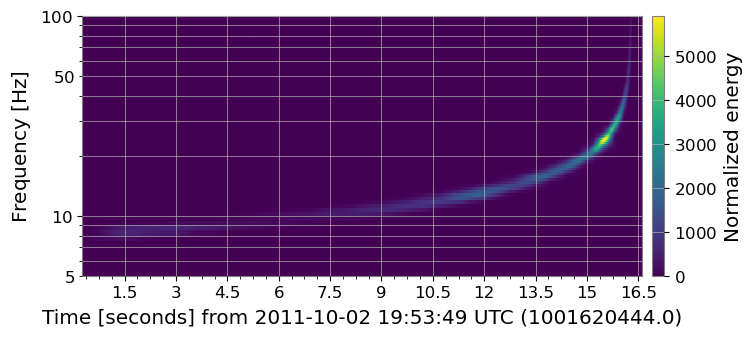

In [158]:
qtrans = tsgwpy_reel_cut.q_transform(frange=(4, 100), qrange=(5, 30))

plot = qtrans.plot(figsize=[8, 4])
ax = plot.gca()
ax.set_ylim(5, 100)
#ax.set_xlim(t0_spectro, tf_spectro)
ax.set_xscale('seconds')
ax.set_yscale('log')
ax.grid(True, axis='y', which='both')
ax.colorbar(cmap='viridis', label='Normalized energy')

TypeError: pcolormesh() takes 1 or 3 positional arguments but 0 were given

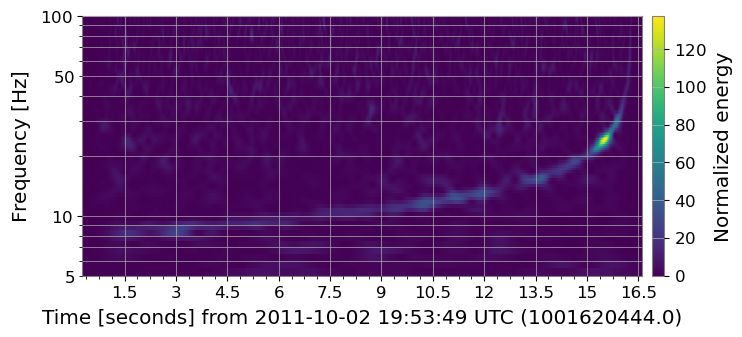

In [178]:
qtrans_res = tsgwpy_res.q_transform(frange=(4, 100), qrange=(5, 30))

plot = qtrans_res.plot(figsize=[8, 4])
ax = plot.gca()
ax.set_ylim(5, 100)
#ax.set_xlim(t0_spectro, tf_spectro)
ax.set_xscale('seconds')
ax.set_yscale('log')
ax.grid(True, axis='y', which='both')
ax.colorbar(cmap='viridis', label='Normalized energy')
ax.pcolormesh(vmin=0, vmax=500)